# Arbol

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,regularizar,targetBooleano

[###] All Done                                              


In [4]:
from utilities import score, score2, evalModels, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_JOBS = -1

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [6]:
runSimple = False
runValidated = False
runReg = False

**Save :** Guardar Modelo (pisa anterior)

In [7]:
saveSimple = True
saveValidated = True
saveReg = True

In [8]:
predictions = pd.DataFrame()

### Preprocesamiento

In [9]:
targetBooleano(df_targ, inplace=True)
reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
df_feat_r = regularizar(df_feat)

In [10]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102356 entries, 74816 to 32535
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   direccion_viento_tarde        102356 non-null  float64
 1   direccion_viento_temprano     102356 non-null  float64
 2   horas_de_sol                  102356 non-null  float64
 3   humedad_tarde                 102356 non-null  float64
 4   humedad_temprano              102356 non-null  float64
 5   llovieron_hamburguesas_hoy    102356 non-null  bool   
 6   mm_evaporados_agua            102356 non-null  float64
 7   mm_lluvia_dia                 102356 non-null  float64
 8   nubosidad_tarde               102356 non-null  float64
 9   nubosidad_temprano            102356 non-null  float64
 10  presion_atmosferica_tarde     102356 non-null  float64
 11  presion_atmosferica_temprano  102356 non-null  float64
 12  rafaga_viento_max_direccion   102356 non-

In [11]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ )
train_targ = train_targ.llovieron_hamburguesas_al_dia_siguiente
val_targ = val_targ.llovieron_hamburguesas_al_dia_siguiente

In [12]:
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ )
train_targ_r = train_targ_r.llovieron_hamburguesas_al_dia_siguiente
val_targ_r = val_targ_r.llovieron_hamburguesas_al_dia_siguiente

## Entrenamiento

### Simple

In [13]:
if (runSimple):
    arbol_simple = DecisionTreeClassifier(
        random_state=1,
        max_depth=3,
        min_samples_split=200
    )
    arbol_simple.fit( train_feat, train_targ )
    
    # Guardar
    if(saveSimple):
        dump(arbol_simple, 'models/Tree/arbol_simple.sk') 
else:
    # Cargar
    arbol_simple = load('models/Tree/arbol_simple.sk')

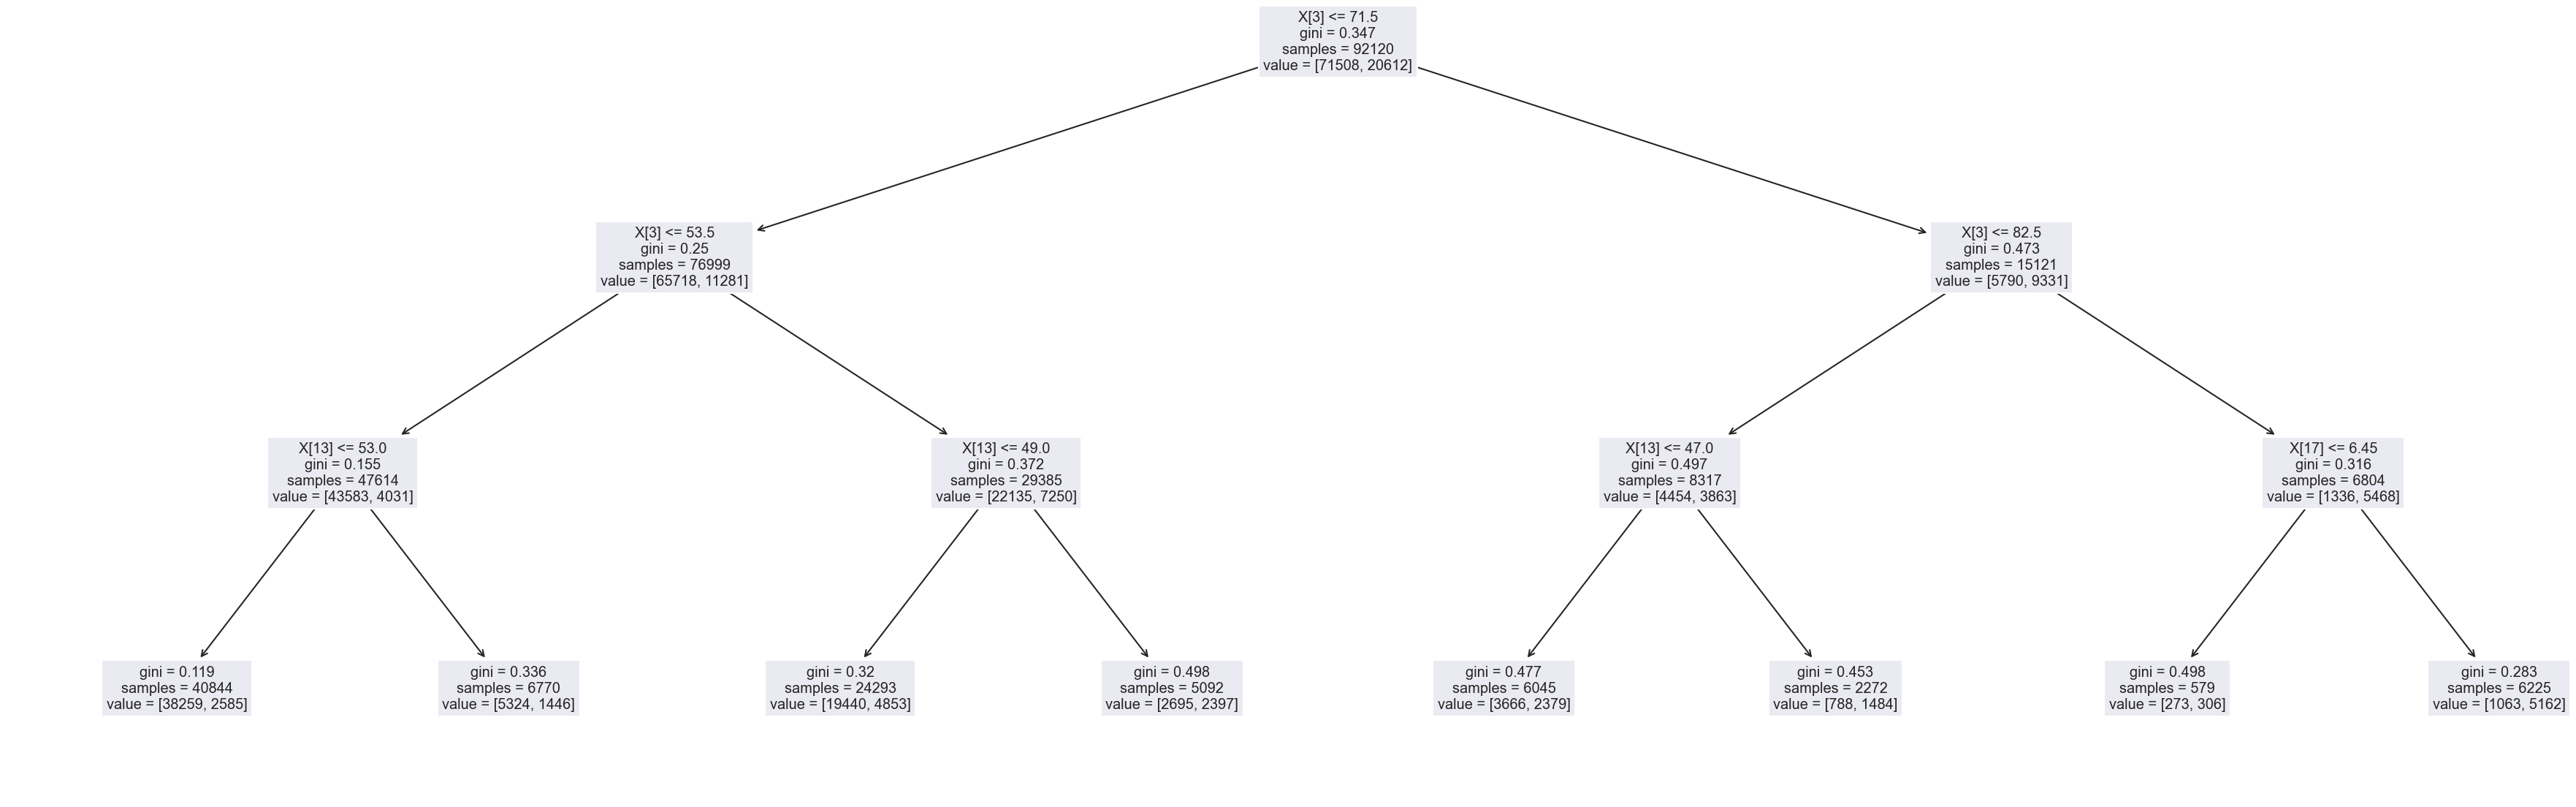

In [14]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_simple);

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
AUC-ROC: 0.7930482173887717
              precision    recall  f1-score   support

       False       0.83      0.97      0.89      7946
        True       0.73      0.33      0.45      2290

    accuracy                           0.82     10236
   macro avg       0.78      0.65      0.67     10236
weighted avg       0.81      0.82      0.80     10236

CONFUSION MATRIX


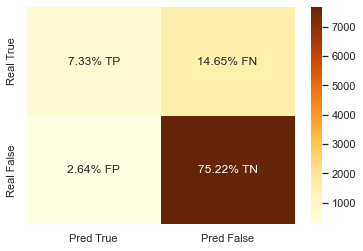

In [15]:
%time
pred = arbol_simple.predict(val_feat)
prob = arbol_simple.predict_proba(val_feat)
score(val_targ,pred, prob[:,1])

In [16]:
pdf = score2('Simple','Numerico Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Optimizando Hiperpametros

In [17]:
if( runValidated ):
    arbol = DecisionTreeClassifier(random_state=1)
    params = {'max_depth': np.arange(1, 20, 1), 'min_samples_leaf': np.arange(50, 1000, 50)}
    
    gridSearch = GridSearchCV(
        arbol,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated):
        dump(gridSearch, 'models/Tree/gridSearch.sk')
else:
    # Cargar
    gridSearch = load('models/Tree/gridSearch.sk')

In [18]:
print(f"Best score: {gridSearch.best_score_}")
print(f"Best params {gridSearch.best_params_}")

Best score: 0.853338267562674
Best params {'max_depth': 12, 'min_samples_leaf': 100}


In [19]:
arbol_grid = gridSearch.best_estimator_

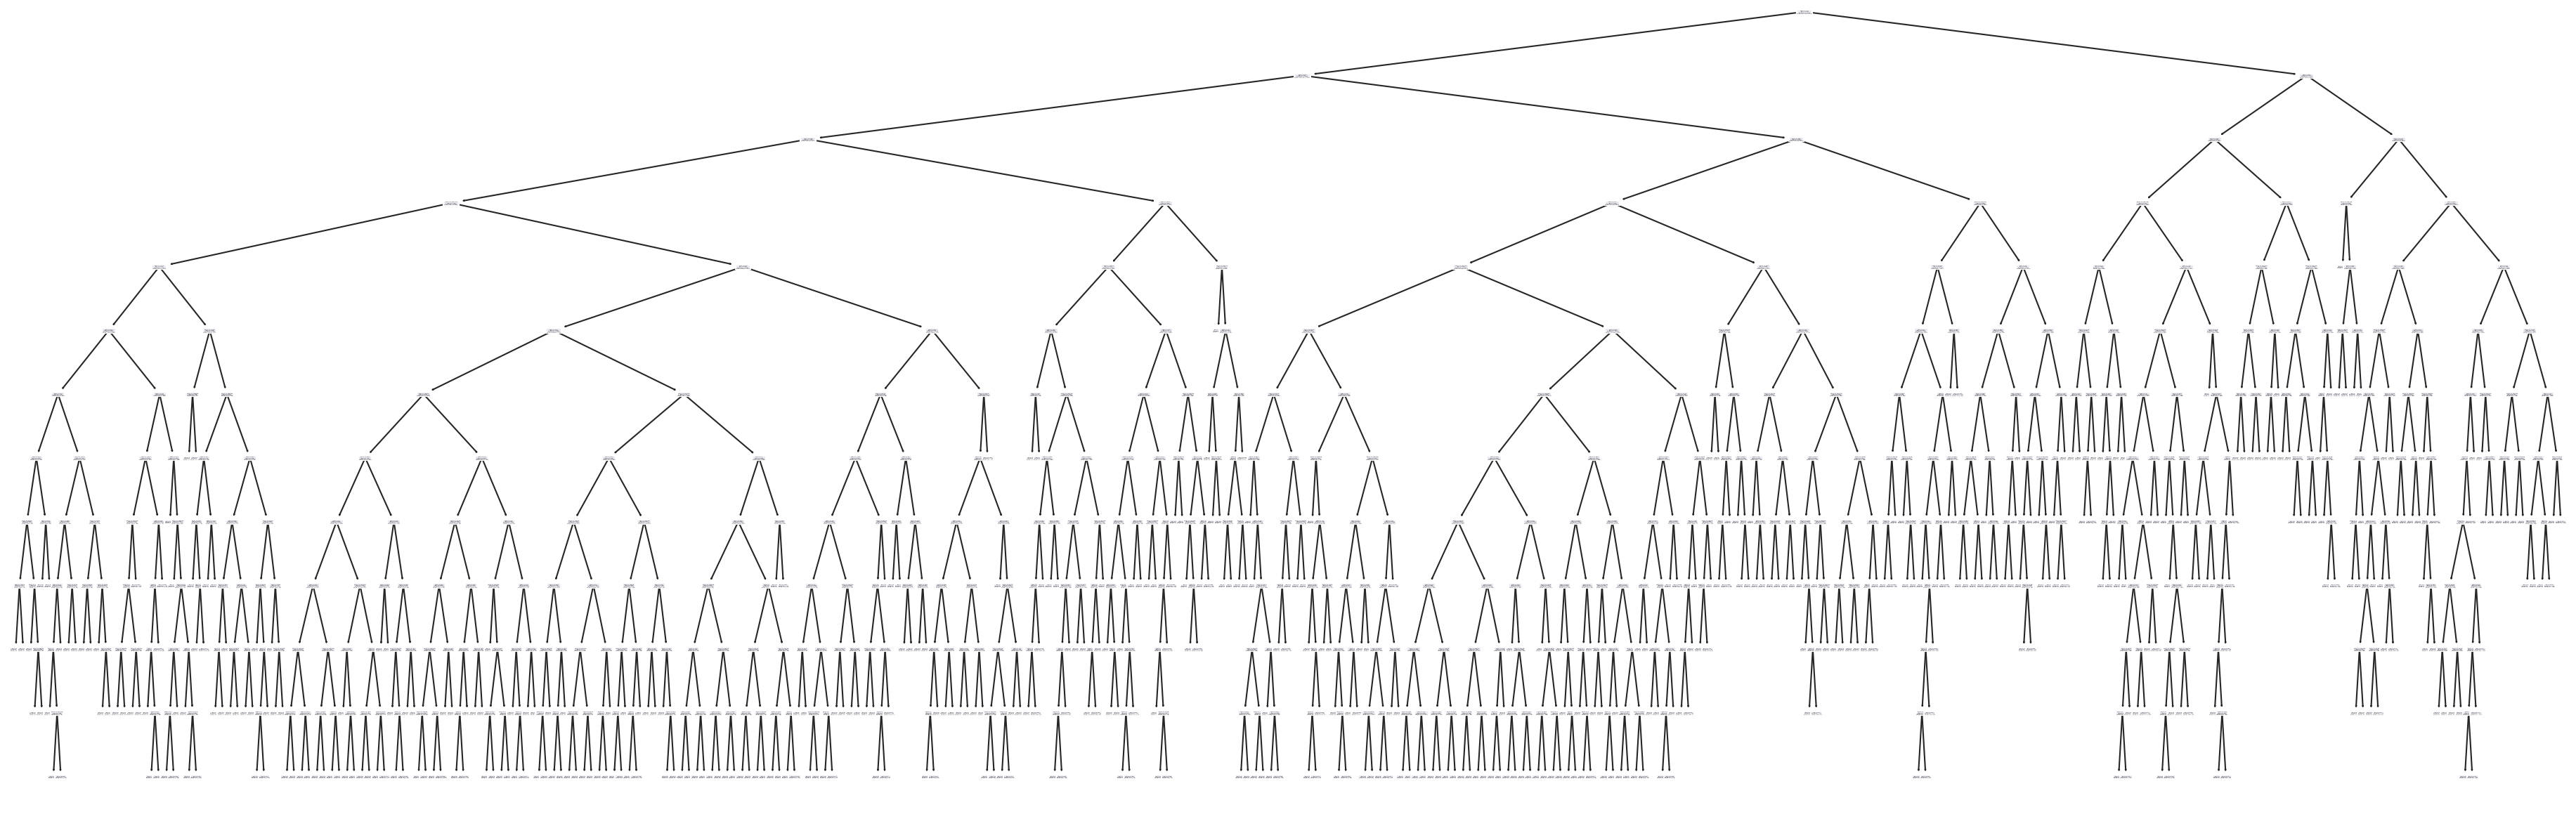

In [20]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_grid);

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
AUC-ROC: 0.8520881122247661
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      7946
        True       0.70      0.46      0.56      2290

    accuracy                           0.84     10236
   macro avg       0.78      0.70      0.73     10236
weighted avg       0.82      0.84      0.82     10236

CONFUSION MATRIX


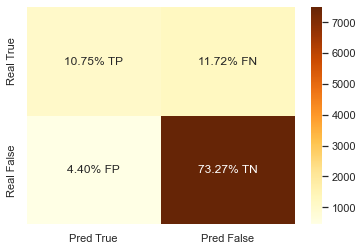

In [21]:
%time
pred = arbol_grid.predict(val_feat)
prob = arbol_grid.predict_proba(val_feat)
score(val_targ,pred, prob[:,1])

In [22]:
pdf = score2('Grid Search','Numerico Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Regularizando

In [23]:
if( runReg ):
    arbol_r = DecisionTreeClassifier(random_state=1)
    params = {'max_depth': np.arange(8, 12, 1), 'min_samples_leaf': np.arange(50, 150, 10)}
    
    grid_r = RandomizedSearchCV(
        arbol_r,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveReg):
        dump(grid_r, 'models/Tree/grid_r.sk')
        dump(grid_r.best_estimator_, 'models/Tree/arbol_r.sk')
else:
    # Cargar
    grid_r = load('models/Tree/grid_r.sk')

In [24]:
print(f"Best score: {grid_r.best_score_}")
print(f"Best params {grid_r.best_params_}")

Best score: 0.8546682576242214
Best params {'min_samples_leaf': 130, 'max_depth': 11}


In [25]:
arbol_r = grid_r.best_estimator_

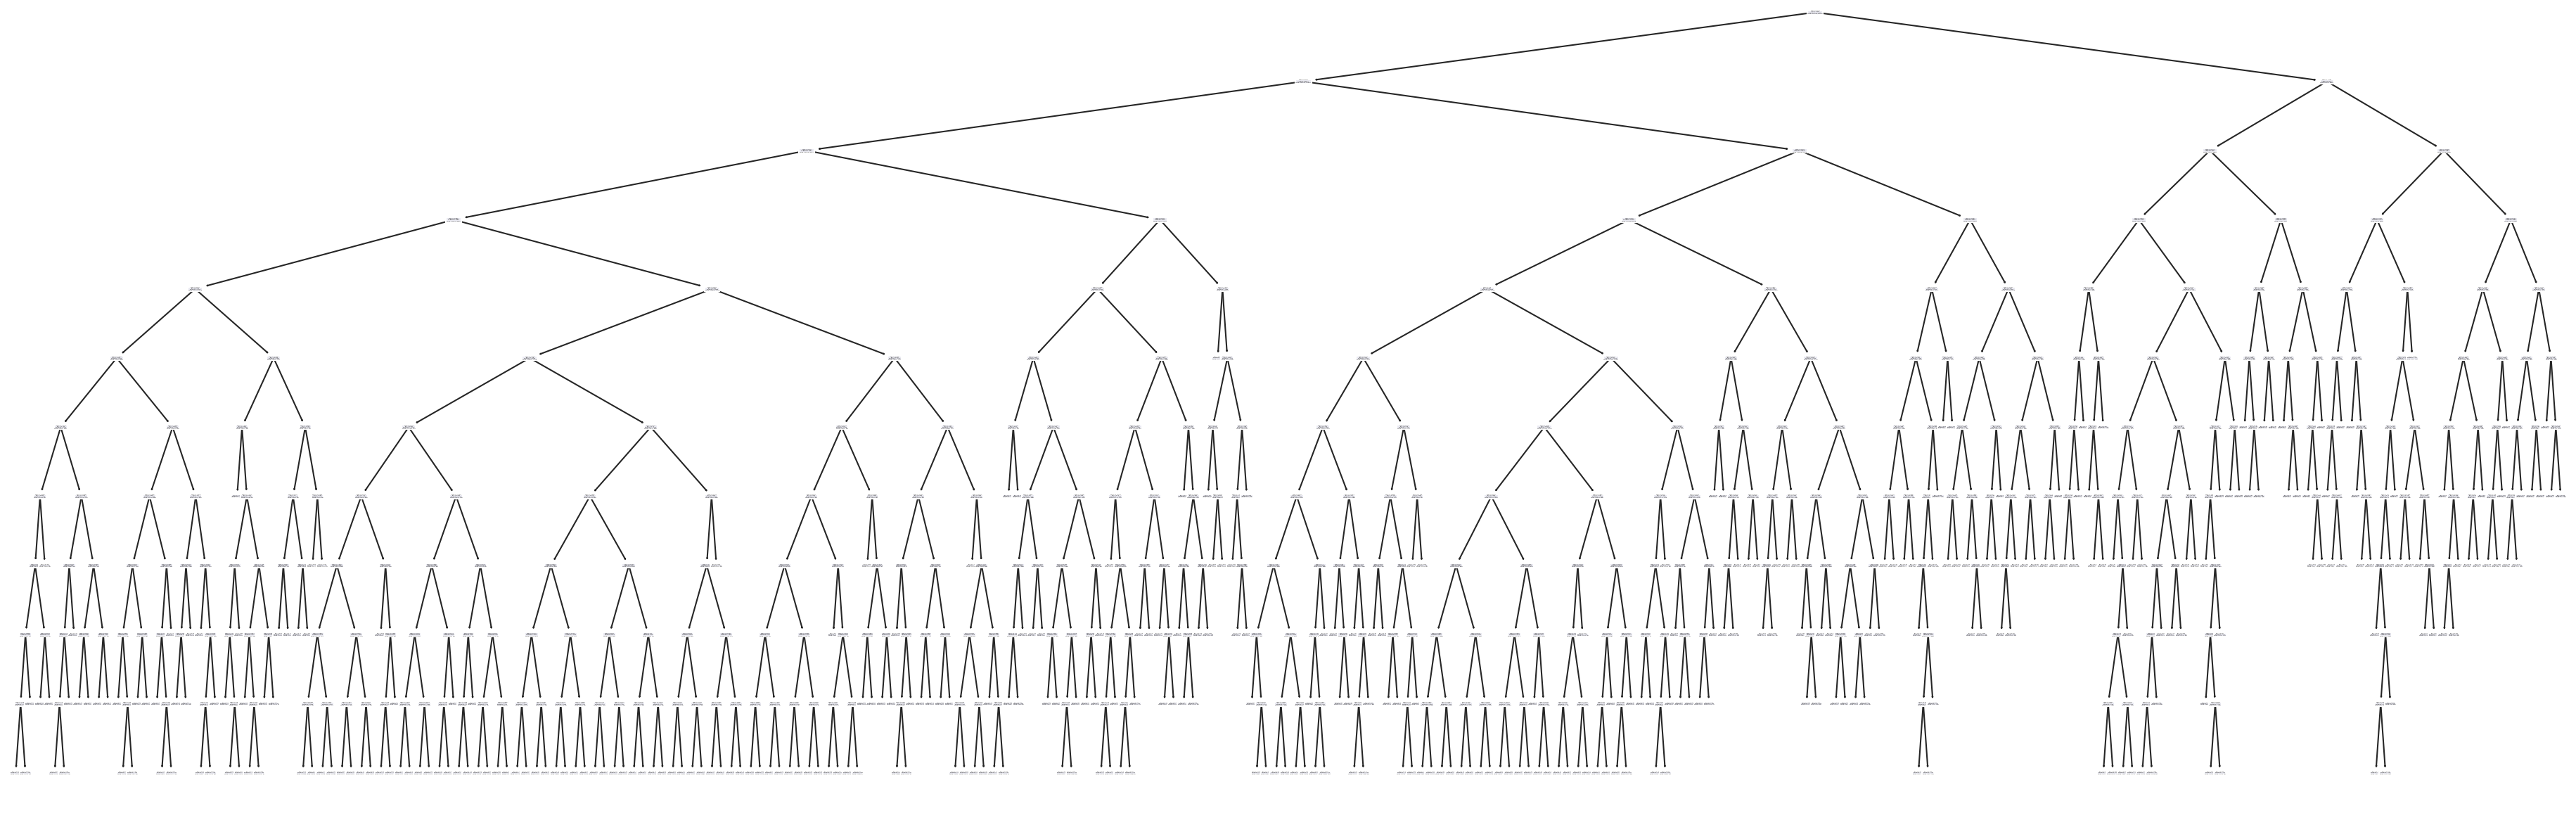

In [26]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_r);

AUC-ROC: 0.8517420536217722
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      7946
        True       0.70      0.46      0.55      2290

    accuracy                           0.83     10236
   macro avg       0.78      0.70      0.73     10236
weighted avg       0.82      0.83      0.82     10236

CONFUSION MATRIX
CPU times: user 152 ms, sys: 14.9 ms, total: 167 ms
Wall time: 133 ms


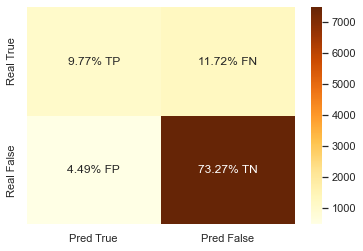

In [27]:
%%time
pred = arbol_r.predict(val_feat_r)
prob = arbol_r.predict_proba(val_feat_r)
score(val_targ_r,pred, prob[:,1])

In [28]:
pdf = score2('Random Search','Regularizado',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

## Resultados

In [29]:
predictions

,Modelo,Preprocesamientos,Clase,AUC-ROC,Accuracy,Precision,Recall,F1 score,Support
0,Simple,Numerico Basico,AVG,0.793048,0.822880,0.810725,0.822880,0.795293,10236
1,Simple,Numerico Basico,True,NaN,NaN,0.734975,0.325764,0.451437,2290
2,Simple,Numerico Basico,False,NaN,NaN,0.832556,0.966146,0.894390,7946
0,Grid Search,Numerico Basico,AVG,0.852088,0.835678,0.823664,0.835678,0.822615,10236
1,Grid Search,Numerico Basico,True,NaN,NaN,0.701592,0.462009,0.557135,2290
2,Grid Search,Numerico Basico,False,NaN,NaN,0.858845,0.943368,0.899124,7946
0,Random Search,Regularizado,AVG,0.851742,0.833919,0.821529,0.833919,0.820716,10236
1,Random Search,Regularizado,True,NaN,NaN,0.695623,0.458079,0.552396,2290
2,Random Search,Regularizado,False,NaN,NaN,0.857814,0.942235,0.898045,7946
